# Figure: within-subject encoding

In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py
import cortex
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy import stats
from scipy.stats import pearsonr, spearmanr

from util import plot
from util.subject import get_confounds
from util.path import Path
from util.stats import ttest_1samp
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS, BLU, ORG

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
modelname = "joint"
# modelname = "joint_nosplit"

features = ["task", "spectral", "articulation", "LLM"]
features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

# encmodel = "encoding_r24"
encmodel = "encoding_t9"
# encmodel = "encoding_t9llama"

# cache = 'nomot'  # no motion confounds at all
# cache = encmodel.split("_")[-1]
cache = 'trialmot9'

FG_MASK = get_brainmask()

modelname, encmodel, cache

('joint', 'encoding_t9', 'trialmot9')

In [4]:
cachedir = f'results/cache/figure2-{encmodel}/{modelname}/{cache}'
!mkdir -p $cachedir
cachedir

'results/cache/figure2-encoding_t9/joint/trialmot9'

In [5]:
prod_cmap = 'Blues'
comp_cmap = 'Oranges'

# Load results

In [6]:
respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

results = defaultdict(list)
for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue
    with h5py.File(respath, "r") as f:
        for key in ["cv_scores_prod", "cv_scores_comp"]:#, "cv_scores"]:
            results[key].append(f[key][...])
        # results['inprod'].append(f['cv_prodmask'][...])

100%|██████████| 58/58 [00:01<00:00, 33.21it/s]


In [7]:
all_scores_prod = np.stack(results["cv_scores_prod"])  # sub, run, feature, voxel
all_scores_comp = np.stack(results["cv_scores_comp"])  # sub, run, feature, voxel
all_scores_lang = (all_scores_prod[:, :, -2] + all_scores_comp[:, :, -1]).mean(1)
# all_scores_lang = (all_scores_prod[:, :, -1] + all_scores_comp[:, :, -1]).mean(1)  # for nosplit
all_scores_prod.shape

(58, 5, 5, 81924)

In [8]:
avg_scores_prod = all_scores_prod.mean((0, 1))
avg_scores_comp = all_scores_comp.mean((0, 1))
avg_scores_lang = avg_scores_prod[-2] + avg_scores_comp[-1]
# avg_scores_lang = avg_scores_prod[-1] + avg_scores_comp[-1]  # for nosplit
avg_scores_prod.shape

(5, 81924)

In [9]:
# all_scores = np.stack(results["cv_scores"])  # sub, run, feature, voxel
# avg_scores = np.mean(all_scores, axis=(0, 1))
# avg_scores.shape

## Statistical test

In [10]:
sigmask = ttest_1samp(all_scores_lang, correlations=False, method='bonf', alpha=0.01)
np.save(cachedir + '/sigmask.npy', sigmask)
sigmask.sum()

36507

# Plot LLM encoding performance

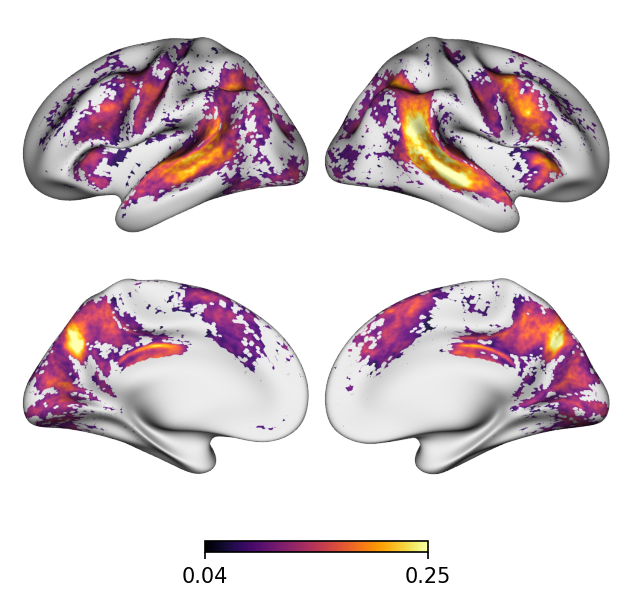

In [17]:
values = avg_scores_lang.copy()

th = ~sigmask

vmin = values[sigmask].min()

fig, ax = plt.subplots()#dpi=300)
plot.surface_plot(values, threshold=th, fig=fig, ax=ax, cmap='inferno', vmin=vmin)#, vmax=0.12)
fig.show()

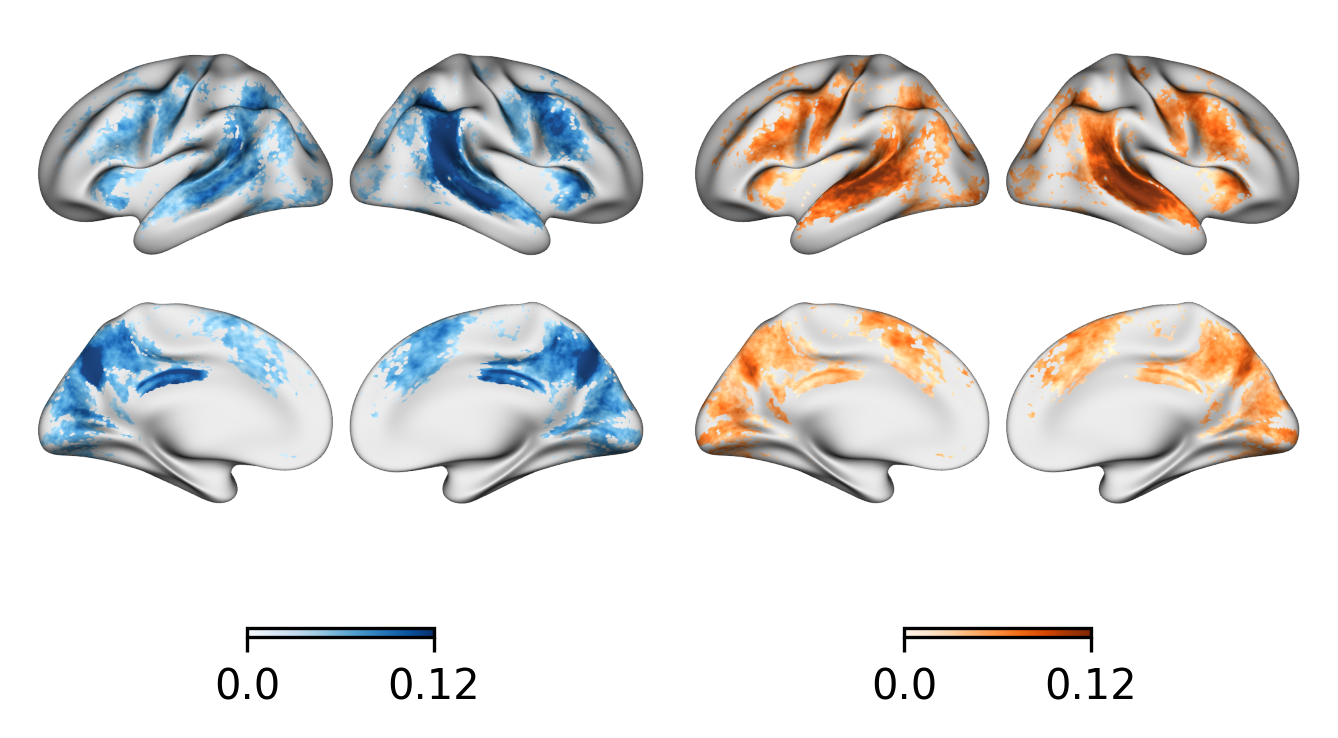

In [20]:
values1 = avg_scores_prod[-2].copy()  # -1 for nosplit
values2 = avg_scores_comp[-1].copy()

th = ~sigmask
# th = None

fig, axes = plt.subplots(1, 2, figsize=(4.5, 4.5), layout='tight', dpi=300)
plot.surface_plot(values1, threshold=th, fig=fig, ax=axes[0], cmap=prod_cmap, vmin=0, vmax=0.12)
plot.surface_plot(values2, threshold=th, fig=fig, ax=axes[1], cmap=comp_cmap, vmin=0, vmax=0.12)
# fig.suptitle(modelname[6:] + f" ({len(features)} spaces) ({cache})")
fig.show()

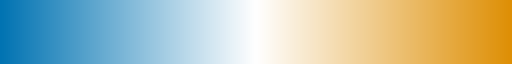

In [31]:
from matplotlib.colors import LinearSegmentedColormap

colors = [BLU, '#ffffff', ORG]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)
cmap

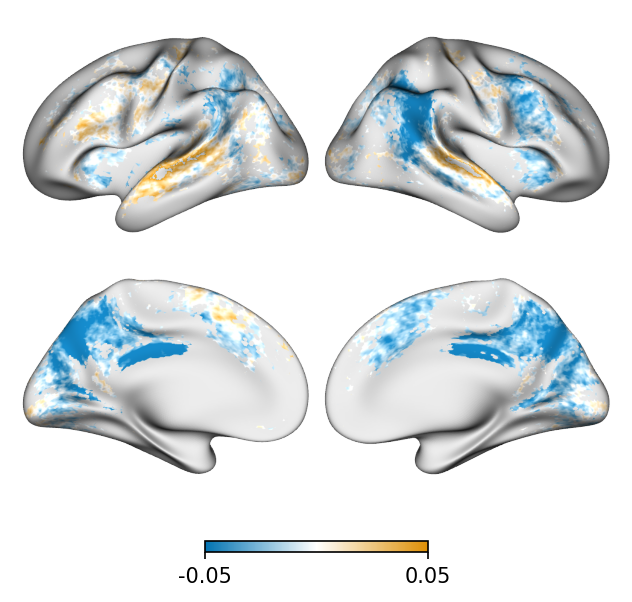

In [32]:
values = values2 - values1

fig, ax = plt.subplots()#dpi=300)
plot.surface_plot(values, threshold=th, fig=fig, ax=ax, cmap=cmap, vmax=0.05)
fig.show()

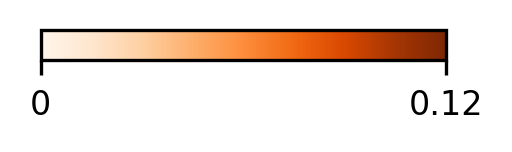

In [84]:
fig = plot.standalone_colorbar('Oranges', tick_labels=(0, 0.12))
fig.show()

# scatter prod and comp

In [39]:
values1 = avg_scores_prod[-2][FG_MASK]
values2 = avg_scores_comp[-1][FG_MASK]

In [40]:
stats.pearsonr(values1, values2), 1/ len(values1)

(PearsonRResult(statistic=0.7311121160344091, pvalue=0.0),
 1.3342762218634503e-05)

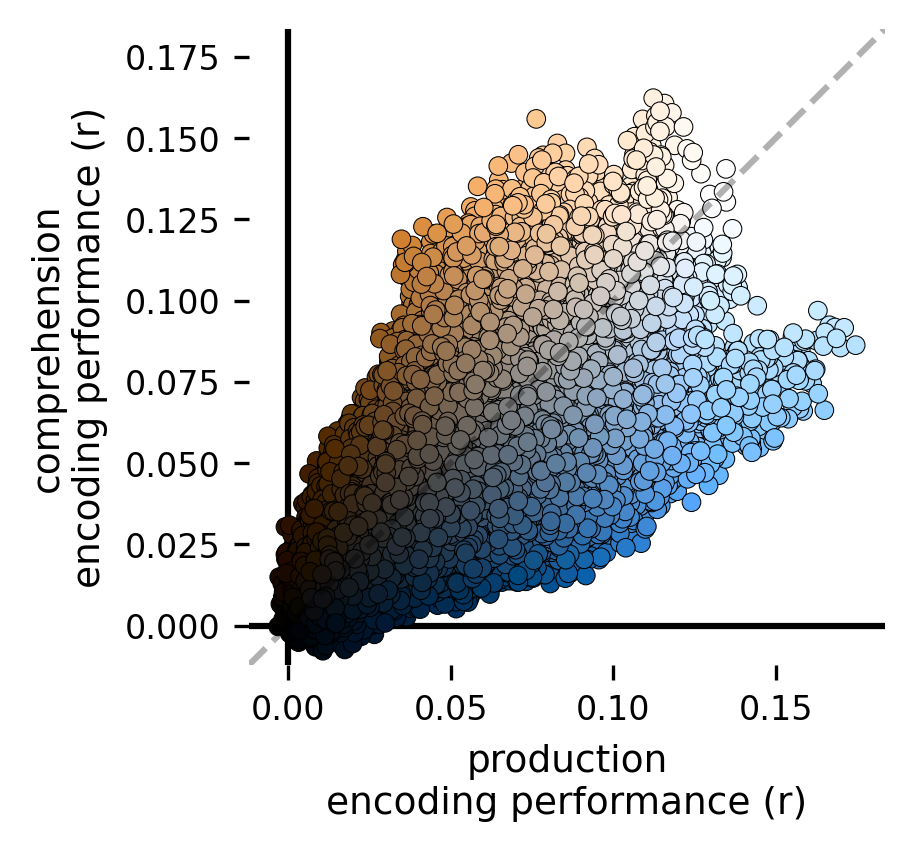

In [16]:
vox_colors = plot.Colormap2D(vmin=0, vmin2=0, vmax=0.13, vmax2=0.13)(
    np.vstack((values1, values2)).T
)
vox_colors = np.stack((vox_colors)).T / 255

fig = plt.figure(figsize=(2.75, 2.75), dpi=300)
ax = fig.add_subplot()

ax.axvline(0, c="k", zorder=1, alpha=1)
ax.axhline(0, c="k", zorder=1, alpha=1)
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, c="k", ls='dashed')
# im = ax.hexbin(values1, values2, bins="log", cmap='grey', gridsize=100)
# im = ax.scatter(values1, values2, color='black', edgecolors="white", linewidths=0.5, s=15, marker='o')
im = ax.scatter(
    values1, values2, c=vox_colors, s=20,
    edgecolors='black', linewidths=0.25, marker='o')
ax.set_aspect("equal", "box")

# roi_labels = {
#     "aTemp": "RH_Lang_aSTS",
#     "pTemp": "RH_Lang_pSTS",
#     "EAC": "RH_AUD_EAC",
# }
# for label, roi in roi_labels.items():
#     roimask = catlas.roimask([roi])
#     x_roi = np.mean(values1[roimask[fgmask]])
#     y_roi = np.mean(values2[roimask[fgmask]])
#     ax.text(
#         x_roi,
#         y_roi,
#         label,
#         ha="center",
#         va="center",
#         size=8,
#         bbox=dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(0.8, 0.8, 0.8)),
#     )

lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], lim)
ax.set_ylim(ax.get_xlim()[0], lim)

ax.set_xlabel("production\nencoding performance (r)")
ax.set_ylabel("comprehension\nencoding performance (r)")

# cbar = fig.colorbar(im, shrink=0.86)
# cbar.set_label("density")

sns.despine(fig, left=True, bottom=True)

fig.show()

# weight similarity

In [33]:
# read
with h5py.File("results/cache/figure3-mbc/joint/trialmot9/wbc.hdf5", "r") as f:
    weight_sim_within = f["within"][...]
weight_sim_within.shape

(58, 81924)

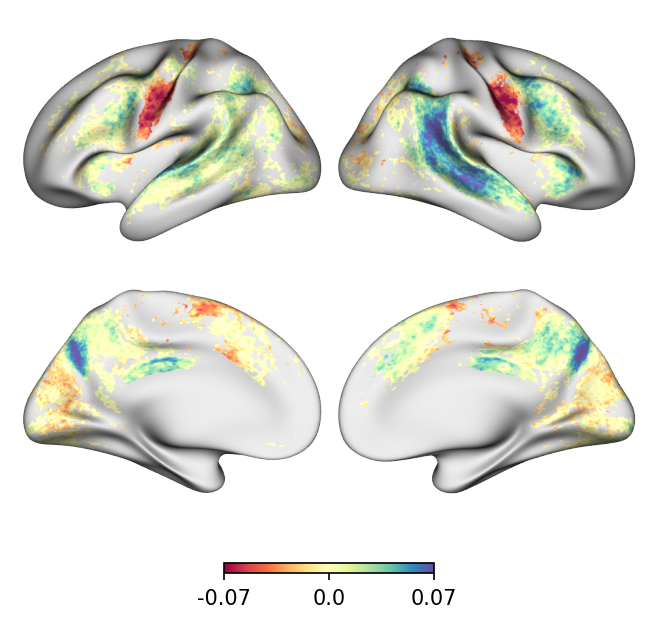

In [38]:
values = weight_sim_within.mean(0)
fig = plot.surface_plot(values, threshold=th, cmap="Spectral")

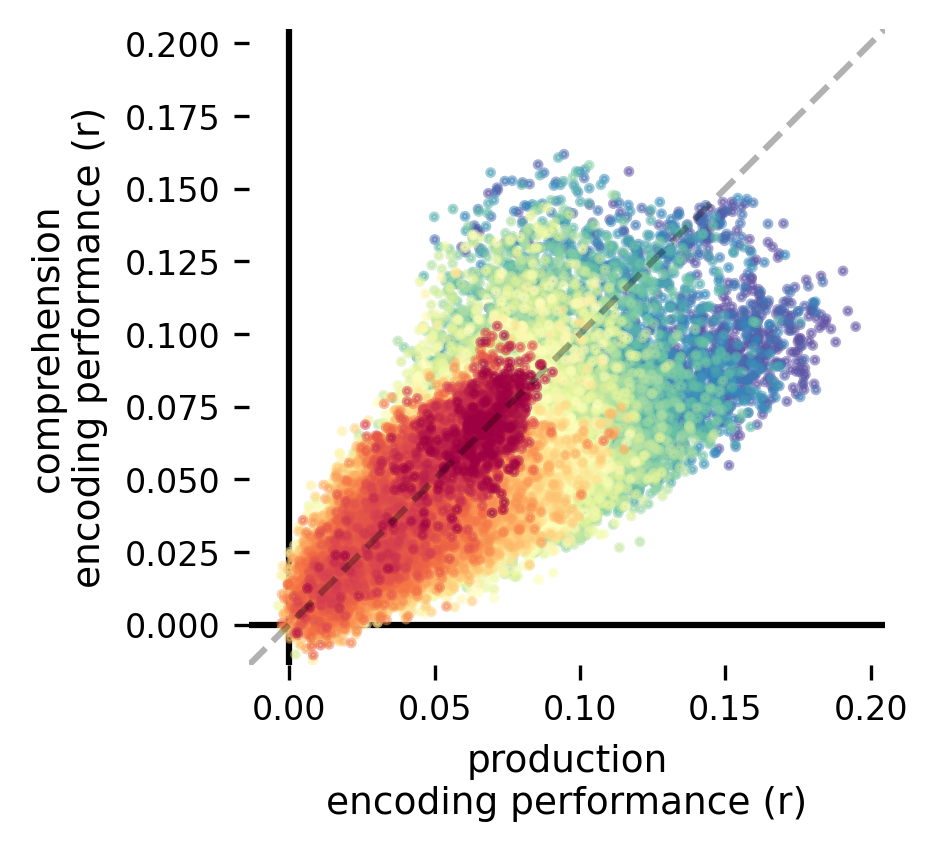

In [64]:
vox_colors = weight_sim_within.mean(0)[FG_MASK]
order = vox_colors.argsort()[::-1]

fig = plt.figure(figsize=(2.75, 2.75), dpi=300)
ax = fig.add_subplot()

ax.axvline(0, c="k", zorder=1, alpha=1)
ax.axhline(0, c="k", zorder=1, alpha=1)
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, c="k", ls='dashed')
im = ax.scatter(
    values1[order], values2[order], c=vox_colors[order],
    s=10, alpha=0.5,
    cmap='Spectral', vmin=-0.07, vmax=0.07,
    # edgecolors='black', linewidths=0.25,
    marker='.')
ax.set_aspect("equal", "box")

lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], lim)
ax.set_ylim(ax.get_xlim()[0], lim)

ax.set_xlabel("production\nencoding performance (r)")
ax.set_ylabel("comprehension\nencoding performance (r)")

# cbar = fig.colorbar(im, shrink=0.86)

sns.despine(fig, left=True, bottom=True)

fig.show()

# encoding performance per feature space

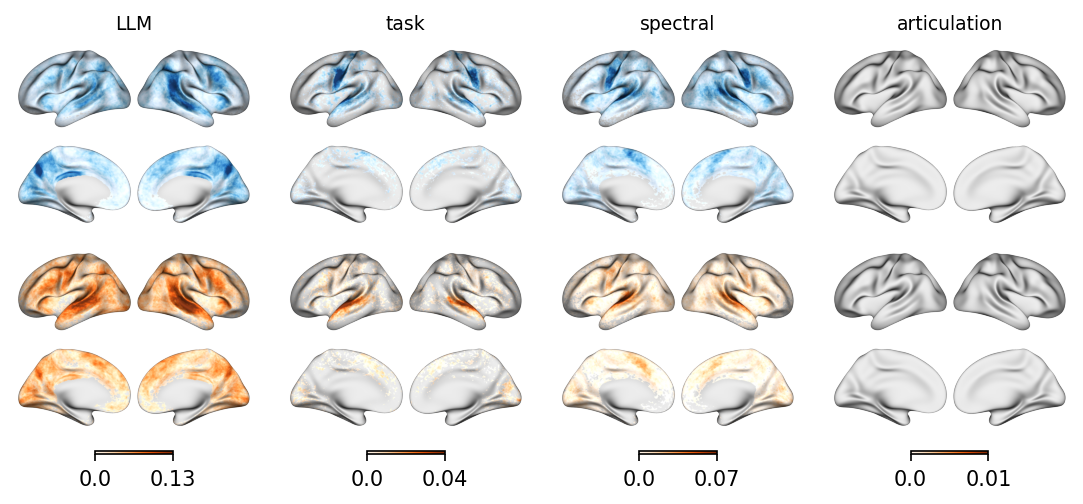

In [52]:
fig, axes = plt.subplots(2, 4, figsize=(7.25, 3.25), layout="constrained")

# joint
# plot.surface_plot(avg_scores_prod.sum(0), fig=fig, ax=axes[0,0], vmin=0.0, cmap="hot")
# plot.surface_plot(avg_scores_comp.sum(0), fig=fig, ax=axes[1,0], vmin=0.0, cmap="hot")

ttest_args = dict(method='fdr_bh', alpha=0.05)
plot_args = dict(vmin=0)

brainmask  = ~ ttest_1samp(np.mean(all_scores_prod[:, :, 0, :] + all_scores_comp[:, :, 0, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_prod[0], threshold=brainmask, fig=fig, ax=axes[0, 1], cmap=prod_cmap, cbar=False, **plot_args)
plot.surface_plot(avg_scores_comp[0], threshold=brainmask, fig=fig, ax=axes[1, 1], cmap=comp_cmap, cbar=True, **plot_args)

brainmask  = ~ ttest_1samp(np.mean(all_scores_prod[:, :, 1, :] + all_scores_comp[:, :, 1, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_prod[1], threshold=brainmask, fig=fig, ax=axes[0, 2], cmap=prod_cmap, cbar=False, **plot_args)
plot.surface_plot(avg_scores_comp[1], threshold=brainmask, fig=fig, ax=axes[1, 2], cmap=comp_cmap, cbar=True, **plot_args)

brainmask  = ~ ttest_1samp(np.mean(all_scores_prod[:, :, 2, :] + all_scores_comp[:, :, 2, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_prod[2], threshold=brainmask, fig=fig, ax=axes[0, 3], cmap=prod_cmap, cbar=False, **plot_args)
plot.surface_plot(avg_scores_comp[2], threshold=brainmask, fig=fig, ax=axes[1, 3], cmap=comp_cmap, cbar=True, **plot_args)

# brainmask  = ~ ttest_sig(np.mean(all_scores_prod[:, :, 3, :] + all_scores_comp[:, :, 4, :], axis=1), **ttest_args)
brainmask  = ~ ttest_1samp(np.mean(all_scores_prod[:, :, 3, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_prod[3], threshold=brainmask, fig=fig, ax=axes[0, 0], cmap=prod_cmap, cbar=False, **plot_args)
brainmask  = ~ ttest_1samp(np.mean(all_scores_comp[:, :, 4, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_comp[4], threshold=brainmask, fig=fig, ax=axes[1, 0], cmap=comp_cmap, cbar=True, **plot_args)

axes[0, 0].set_title("LLM")
axes[0, 1].set_title("task")
axes[0, 2].set_title("spectral")
axes[0, 3].set_title("articulation")

axes[0, 0].set_ylabel('production')
axes[1, 0].set_ylabel('comprehension')

fig.show()

# Joint ROI-level

In [11]:
catlas = Atlas.load("custom_glasser_group")

In [12]:
scoresP = catlas.vox_to_parc(avg_scores_prod)
scoresC = catlas.vox_to_parc(avg_scores_comp)
scoresP.shape

(5, 22)

In [13]:
df = pd.DataFrame(index=catlas.labels)
df["task"] = scoresP[0] + scoresC[0]
df["spectral"] = scoresP[1] + scoresC[1]
df["articulation"] = scoresP[2] + scoresC[2]
df["prod-LLM"] = scoresP[3]
df["comp-LLM"] = scoresC[4]
df.head()

task  spectral  articulation  prod-LLM  comp-LLM
LH_EAC   0.040519  0.123370      0.005974  0.055076  0.056290
LH_pSTG  0.026039  0.064692      0.007974  0.080359  0.076738
LH_aSTG  0.044376  0.061195      0.007238  0.065741  0.086863
LH_IFG   0.017038  0.028366      0.006036  0.048375  0.052135
LH_MFG   0.026356  0.062188      0.007071  0.067626  0.063574

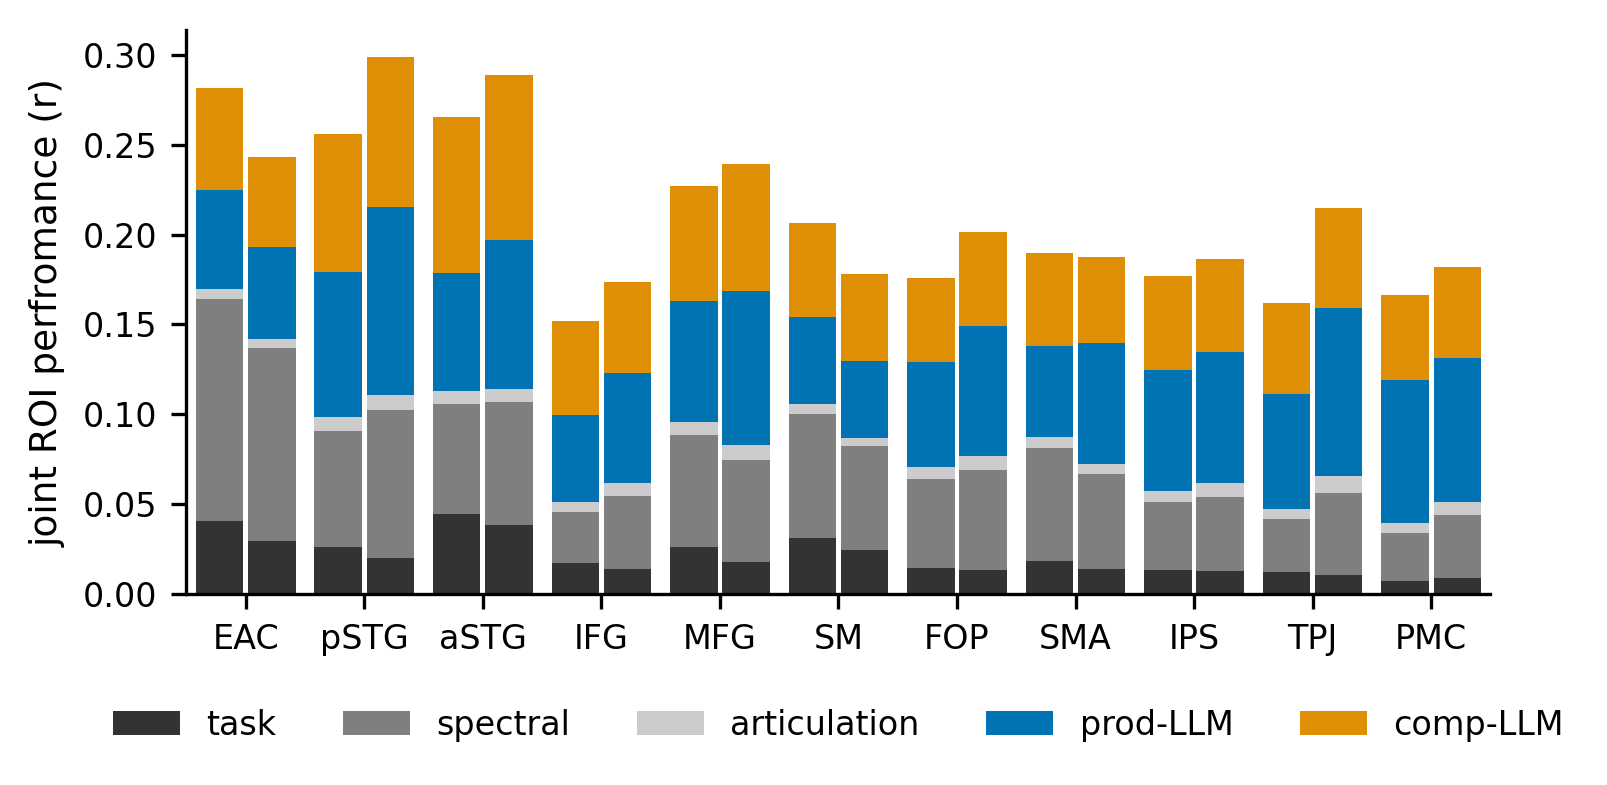

In [14]:
width = 0.4

# fig, ax = plt.subplots(figsize=(7.25, 2.8), layout='constrained', dpi=300)
fig, ax = plt.subplots(figsize=(5.25, 2.5), layout='constrained', dpi=300)

subdf1 = df.iloc[:len(df)//2]
subdf = df.iloc[len(df)//2:]
xlabels = subdf.index
bottom = np.zeros(len(xlabels))
colors = ["#333333", "#7f7f7f", "#CCCCCC", BLU, ORG]

xaxis = np.arange(len(xlabels))

for feature, color in zip(features, colors):
    values = subdf1[feature]
    p = ax.bar(xaxis - .02, values, -width, bottom=bottom, color=color, align='edge')
    bottom += values

bottom = np.zeros(len(xlabels))

for feature, color in zip(features, colors):
    values = subdf[feature]
    p = ax.bar(xaxis + .02, values, width, label=feature, bottom=bottom, color=color, align='edge')
    bottom += values

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels([label.split('_')[1] for label in xlabels])

gap = .1
ax.set_xlim(-width-gap, 10+width+gap)

ax.set_ylabel('joint ROI perfromance (r)')
# ax.legend(loc="upper left", frameon=False, bbox_to_anchor=(0.98, 1))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
sns.despine(fig)

fig.show()

## plot brains

In [15]:
from surfplot import Plot

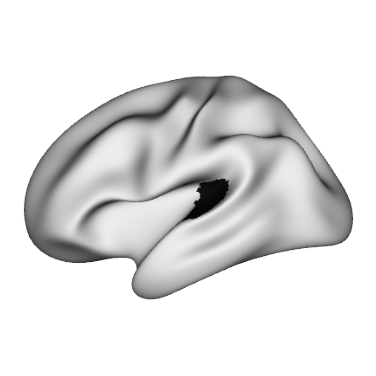

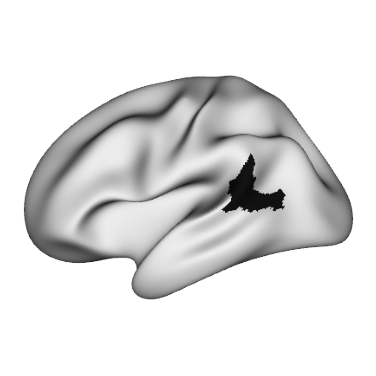

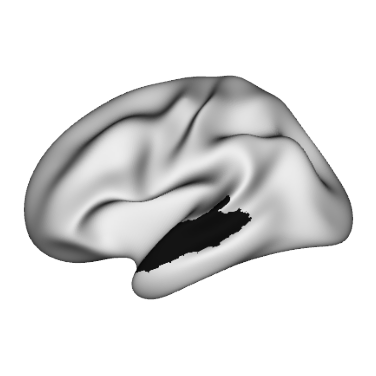

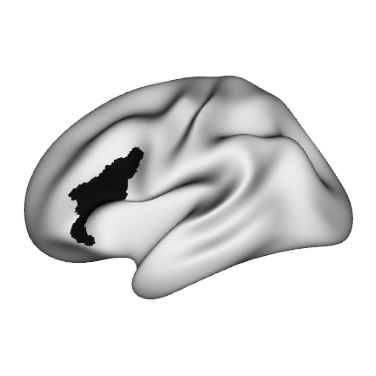

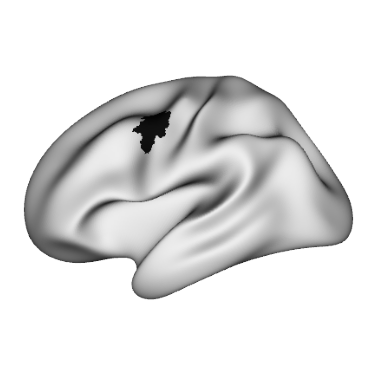

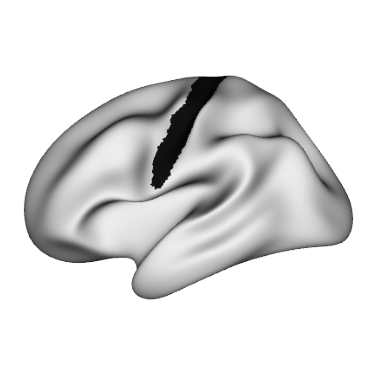

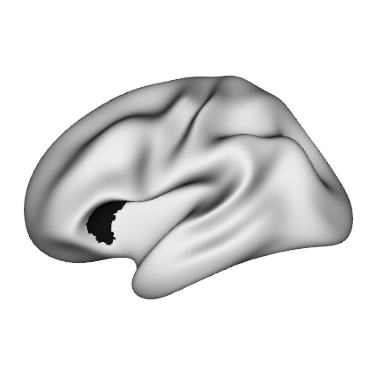

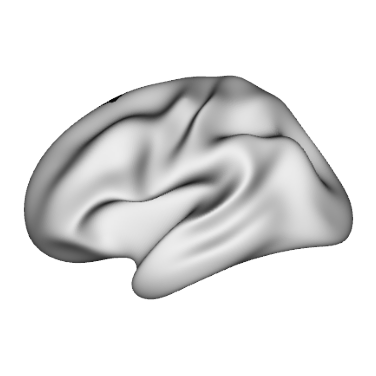

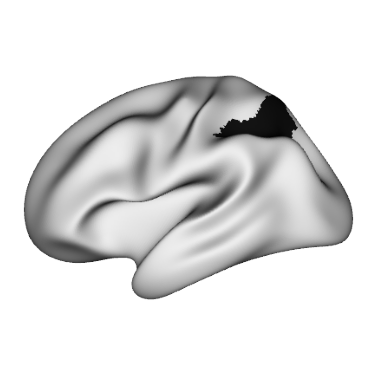

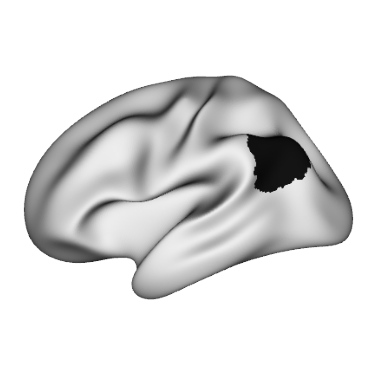

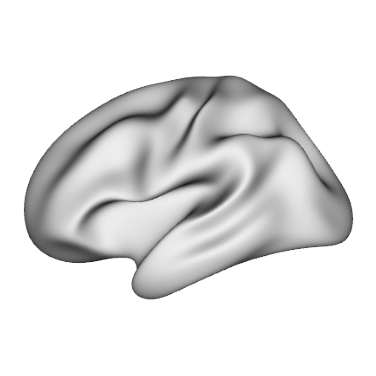

In [16]:
for i, label in enumerate(catlas.labels[:len(catlas)//2], 1):
    roimask = catlas.roimask([i]).astype(int)

    view = 'lateral'
    if 'LangS' in label or 'DMN' in label:
        view = 'medial'

    p = Plot("mats/suma-fsaverage6/lh.inf_120.gii", views=view, brightness=0.7, size=(200, 200), zoom=1.2)
    p.add_layer(roimask[:roimask.size//2], cmap='Grays', color_range=(0, 1), cbar=False)
    fig = p.build()
    fig.show()

# compare with head motion

In [57]:
stat = np.mean

prod_fds = []
comp_fds = []
prod_scs = []
comp_scs = []

for subA in tqdm(SUBS_STRANGERS):
    fd = get_confounds(subA, confounds=['framewise_displacement'])
    fd = fd.reshape(5, 240)

    encpath = Path(root='results/' + encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        prod_mask = f["cv_prodmask"][...]
        prod_scores = f["cv_scores_prod"][:, -2]
        comp_scores = f["cv_scores_comp"][:, -1]
    
    for i in range(5):
        prod_fd = fd[i, prod_mask[i]]
        comp_fd = fd[i, ~prod_mask[i]]
        prod_sc = prod_scores[i]
        comp_sc = comp_scores[i]

        prod_fds.append(stat(prod_fd, axis=-1))
        comp_fds.append(stat(comp_fd, axis=-1))
        prod_scs.append(stat(prod_sc, axis=-1))
        comp_scs.append(stat(comp_sc, axis=-1))


100%|██████████| 58/58 [00:14<00:00,  4.05it/s]


In [65]:
r_prod = stats.pearsonr(prod_fds, prod_scs)
r_comp = stats.pearsonr(comp_fds, comp_scs)
print(r_prod)
print(r_comp)

PearsonRResult(statistic=-0.32828994166683145, pvalue=1.0288419505222912e-08)
PearsonRResult(statistic=-0.20601913799203203, pvalue=0.00041370693156332584)


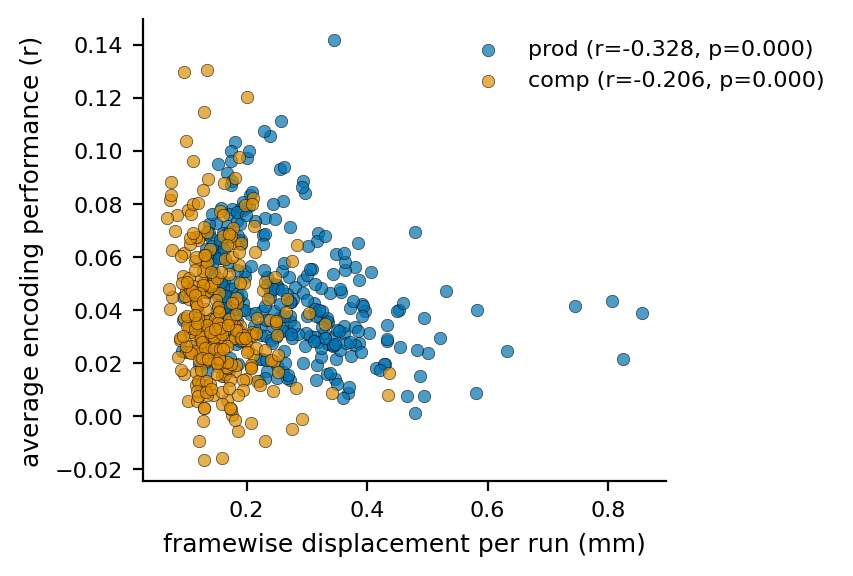

In [79]:
fig, ax = plt.subplots(figsize=(3.375, 3), dpi=200)

ax.scatter(prod_fds, prod_scs, alpha=0.7, c=BLU, s=20, label=f'prod (r={r_prod.statistic:.3f}, p={r_prod.pvalue:.3f})', edgecolors='black', linewidths=0.25)
ax.scatter(comp_fds, comp_scs, alpha=0.7, c=ORG, s=20, label=f'comp (r={r_comp.statistic:.3f}, p={r_comp.pvalue:.3f})', edgecolors='black', linewidths=0.25)
ax.set_xlabel('framewise displacement per run (mm)')
ax.set_ylabel('average encoding performance (r)')
ax.legend(loc="upper left", bbox_to_anchor=(0.58, 1))
fig.show()

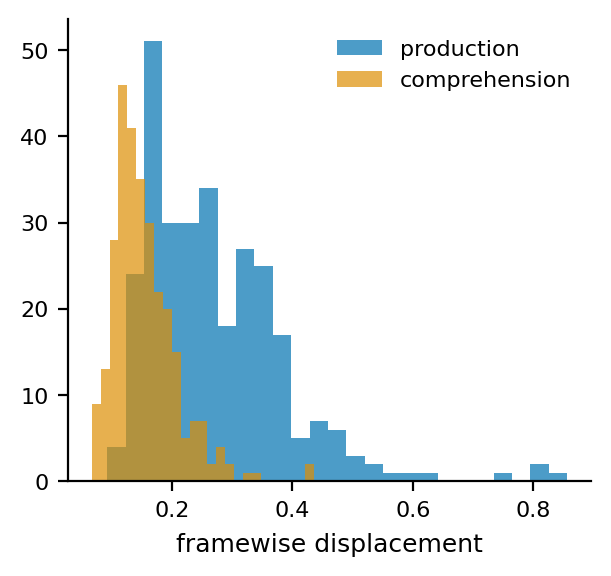

In [80]:
fig, ax = plt.subplots(figsize=(3.375, 3), dpi=200)
ax.hist(prod_fds, bins=25, alpha=0.7, color=BLU, label='production')
ax.hist(comp_fds, bins=25, alpha=0.7, color=ORG, label='comprehension')
ax.legend()
ax.set_xlabel('framewise displacement')
fig.show()